In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta

from utils.labels import detect_head_and_shoulders, detect_double_bottom, label_patterns, create_windows
from utils.classify_window import classify_window
from utils.forecaster import forecaster
from model.CNN.CNN1D import CNN1D_MultiChannel
from model.CNN.CNN2D import CNN2D_MultiChannel
from trainers.CNN1DTrainer import CNN1DTrainer, TimeSeries1DDataset
from trainers.CNN2DTrainer import CNN2DTrainer, TimeSeries2DDataset


In [2]:
filepath = "data"
filename = "NIFTY 50_minute_data.csv"
# filename = "NIFTY 50_daily_data.csv"

file = f"{filepath}/{filename}"

df_nifty50_full = pd.read_csv(file)
df_nifty50_full.shape

(932946, 6)

In [3]:
df_nifty50 = df_nifty50_full[-100000:]

In [4]:
df_nifty50.loc[:, "ema"] = ta.ema(df_nifty50['close'], length=15)
df_nifty50.loc[:, "rsi"] = ta.rsi(df_nifty50['close'], length=15)
df_nifty50.loc[:, "zscore"] = ta.zscore(df_nifty50['close'], length=15)

df_nifty50.dropna(inplace=True)
df_nifty50.reset_index(drop=True, inplace=True)

# df['EMA'] = ta.ema(df['Close'], length=5)
# df['MACD'] = ta.macd(df['Close'])['MACD_12_26_9']
# df['RSI'] = ta.rsi(df['Close'], length=14)

/tmp/ipykernel_88920/2254231990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nifty50.loc[:, "ema"] = ta.ema(df_nifty50['close'], length=15)
/tmp/ipykernel_88920/2254231990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nifty50.loc[:, "rsi"] = ta.rsi(df_nifty50['close'], length=15)
/tmp/ipykernel_88920/2254231990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

In [5]:
df_nifty50.tail()

,date,open,high,low,close,volume,ema,rsi,zscore
99980,2025-02-07 15:25:00,23569.45,23570.60,23567.00,23568.10,0,23565.947842,60.730654,-0.686194
99981,2025-02-07 15:26:00,23568.10,23570.25,23565.30,23567.40,0,23566.129362,60.228034,-0.795776
99982,2025-02-07 15:27:00,23569.00,23578.35,23565.40,23576.50,0,23567.425691,64.338901,0.356366
99983,2025-02-07 15:28:00,23577.05,23578.60,23567.45,23568.10,0,23567.509980,58.371835,-0.729732
99984,2025-02-07 15:29:00,23568.10,23571.35,23557.35,23563.15,0,23566.964982,55.142854,-1.212804


In [6]:
WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

In [7]:
df_nifty_labelled = pd.DataFrame.from_dict(label_patterns(df_nifty50))

In [8]:
df_nifty_labelled.label.value_counts()

label
double_bottom         58464
none                  34189
ascending_triangle     5922
head_and_shoulders     1400
Name: count, dtype: int64

In [9]:

window_tensors, target = create_windows(df_nifty_labelled)
window_tensors[0]


tensor([[2.1739e+04, 2.1731e+04, 5.8809e+01, 1.3655e+00],
        [2.1742e+04, 2.1733e+04, 6.2139e+01, 1.7213e+00],
        [2.1736e+04, 2.1733e+04, 5.3502e+01, 7.0540e-01],
        [2.1740e+04, 2.1734e+04, 5.7230e+01, 1.1048e+00],
        [2.1734e+04, 2.1734e+04, 5.0537e+01, 1.9853e-01],
        [2.1741e+04, 2.1735e+04, 5.7162e+01, 1.1267e+00],
        [2.1743e+04, 2.1736e+04, 5.8968e+01, 1.2573e+00],
        [2.1741e+04, 2.1737e+04, 5.6189e+01, 8.0460e-01],
        [2.1744e+04, 2.1737e+04, 5.9106e+01, 1.2907e+00],
        [2.1741e+04, 2.1738e+04, 5.5001e+01, 5.3924e-01]])

In [10]:
window_tensors.shape

torch.Size([99975, 10, 4])

/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)  # e.g., (N, 15, 4) or (N, 4, 15)
/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


torch.Size([79980, 4, 10])
torch.Size([19995, 4, 10])
Validation Loss: 0.6991 | Accuracy: 0.8099 | F1: 0.5755
Epoch [1/10], Loss: 0.7841, Accuracy: 0.7563, F1: 0.4726
Validation Loss: 0.5816 | Accuracy: 0.8783 | F1: 0.6753
Epoch [2/10], Loss: 0.6323, Accuracy: 0.8460, F1: 0.6569
Validation Loss: 0.5422 | Accuracy: 0.8988 | F1: 0.7538
Epoch [3/10], Loss: 0.5629, Accuracy: 0.8878, F1: 0.7387
Validation Loss: 0.5106 | Accuracy: 0.9166 | F1: 0.7820
Epoch [4/10], Loss: 0.5221, Accuracy: 0.9113, F1: 0.7827
Validation Loss: 0.4993 | Accuracy: 0.9256 | F1: 0.8178
Epoch [5/10], Loss: 0.4981, Accuracy: 0.9257, F1: 0.8101
Validation Loss: 0.4770 | Accuracy: 0.9366 | F1: 0.8303
Epoch [6/10], Loss: 0.4804, Accuracy: 0.9346, F1: 0.8276
Validation Loss: 0.5122 | Accuracy: 0.9136 | F1: 0.7935
Epoch [7/10], Loss: 0.4673, Accuracy: 0.9419, F1: 0.8458
Validation Loss: 0.4662 | Accuracy: 0.9413 | F1: 0.8418
Epoch [8/10], Loss: 0.4566, Accuracy: 0.9472, F1: 0.8550
Validation Loss: 0.4571 | Accuracy: 0.9470

/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_input, dtype=torch.float32)


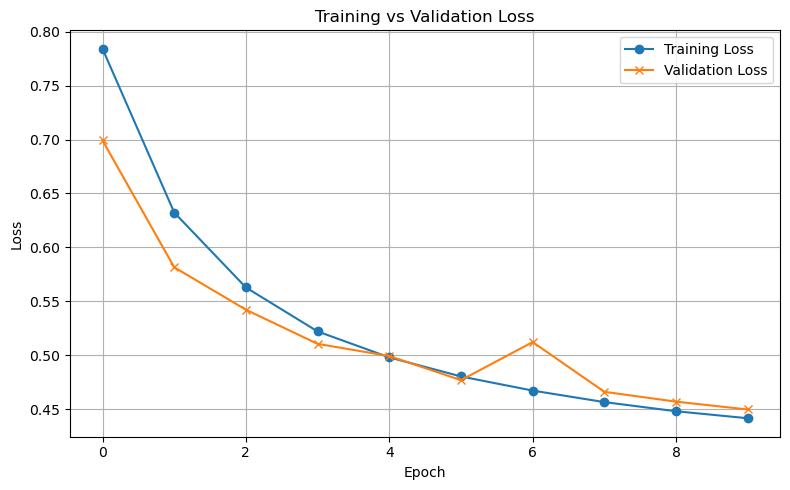

In [11]:
# window_tensors_CNN2D = window_tensors.transpose(0, 2, 1).reshape(-1, 4, 5, 3)

X_train, X_val, y_train, y_val = train_test_split(window_tensors, target, test_size=0.2)

model = CNN1D_MultiChannel(num_classes=4)

trainer = CNN1DTrainer(model, X_train, y_train, X_val, y_val, batch_size=32, lr=1e-3)

trainer.train(num_epochs=10)
trainer.evaluate()

trainer.save_model("models_results/checkpoints/CNN1D_MULTICHANNEL.pt")

predictions = trainer.predict(X_val[:5])
print("Predicted classes:", predictions)

trainer.plot_losses()


In [13]:
predictions = trainer.predict(X_val[:2])
print("Predicted classes:", list(predictions))

Predicted classes: [1, 1]


/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN2DTrainer.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN2DTrainer.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Validation Loss: 0.7982 | Accuracy: 0.7607 | F1:0.3875
Epoch [1/10] | Train Loss: 0.8832 | Val Loss: 0.7982 | Train Acc: 0.7019 | F1: 0.3500
Validation Loss: 0.6920 | Accuracy: 0.8229 | F1:0.5413
Epoch [2/10] | Train Loss: 0.7258 | Val Loss: 0.6920 | Train Acc: 0.7953 | F1: 0.4373
Validation Loss: 0.6247 | Accuracy: 0.8517 | F1:0.5542
Epoch [3/10] | Train Loss: 0.6472 | Val Loss: 0.6247 | Train Acc: 0.8405 | F1: 0.5308
Validation Loss: 0.5880 | Accuracy: 0.8747 | F1:0.6395
Epoch [4/10] | Train Loss: 0.5988 | Val Loss: 0.5880 | Train Acc: 0.8673 | F1: 0.6009
Validation Loss: 0.5655 | Accuracy: 0.8845 | F1:0.6216
Epoch [5/10] | Train Loss: 0.5688 | Val Loss: 0.5655 | Train Acc: 0.8851 | F1: 0.6564
Validation Loss: 0.5466 | Accuracy: 0.8964 | F1:0.7096
Epoch [6/10] | Train Loss: 0.5466 | Val Loss: 0.5466 | Train Acc: 0.8981 | F1: 0.7096
Validation Loss: 0.5421 | Accuracy: 0.8977 | F1:0.7364
Epoch [7/10] | Train Loss: 0.5303 | Val Loss: 0.5421 | Train Acc: 0.9073 | F1: 0.7408
Validation Lo

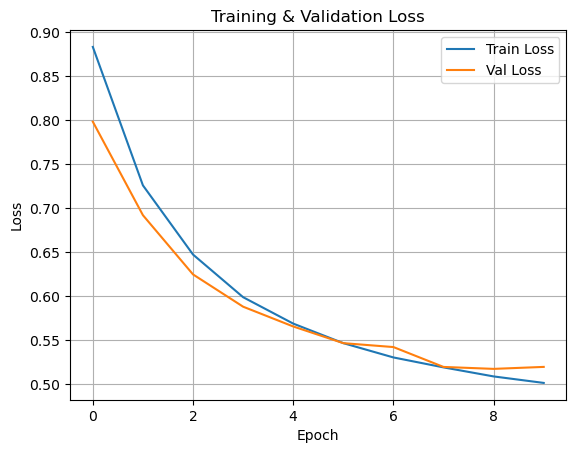

In [14]:
model = CNN2D_MultiChannel(in_channels=4, num_classes=4)
trainer = CNN2DTrainer(model, X_train, y_train, X_val, y_val, batch_size=32, lr=1e-3)
trainer.train(num_epochs=10)
trainer.evaluate()
trainer.save_model("models_results/checkpoints/CNN2D_MULTICHANNEL.pt")
trainer.plot_losses()

In [18]:

classify_window(window_tensors[12], model_type='2d', model_path="models_results/checkpoints/CNN2D_MULTICHANNEL.pt", PATTERN_LABELS=PATTERN_LABELS)

'double_bottom'